# Loading new data

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from modules import *
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import glob
import tqdm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import cm
import itertools

In [2]:
# file = "H:\Github\Antarctica-M.2\data\land ice\GRCTellus.JPL.200204_202008.GLO.RL06M.MSCNv02CRI.nc"
# ds = xr.open_dataset(file)
# ds

In [3]:
# data  = ds.lwe_thickness

In [4]:
# trend = data.polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1).sel(lat=slice(-90,-50))

# ax = plt.axes(projection=ccrs.SouthPolarStereo())
# contour = ax.contourf(trend.lon, trend.lat, trend.values, transform=ccrs.PlateCarree(), cmap = 'RdBu')
# plt.colorbar(contour)
# ax.coastlines()
# plt.show()

# Temperature

In [5]:
files = glob.glob('processed_data/*')
variables  = ['t2m.nc', 'skt.nc', 'sst.nc']
files = [f for f in files if '_' not in f.split('\\')[1] and  f.split('\\')[1] in variables]
ds = xr.open_mfdataset(files, parallel=True, compat='override')

ds = ds.compute()

In [6]:
ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
#       .pipe(w5.normalise_indepenant, dependant='sic')
     )
ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4128 -0.427 -0.4652
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.4215 -0.4357 -0.4746
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -0.3717 -0.3767 -0.3875

In [7]:
area = xr.open_dataset('data/area_files/processed_nsidc.nc').area

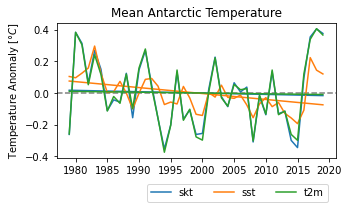

In [8]:
fig = plt.figure(figsize=(5,2.5))
plt.axhline(0, color = 'black',alpha = 0.5, linestyle='--')
gradient = xr.Dataset()
for t in ds:
    data = (ds[t]*area).mean(dim=('x','y'))/area.mean(dim=('x','y'))
    m, b = data.polyfit(deg=1, dim='time').polyfit_coefficients 
    yfit = m*data.time.astype(float) +b
    plot = plt.plot(data.time, data,label = t)
    plt.plot(data.time, yfit, color = plot[0].get_color())
plt.legend(bbox_to_anchor=(0.99, -0.15), ncol = 3, loc = 'upper right')
plt.title('Mean Antarctic Temperature')
plt.ylabel('Temperature Anomaly [$\degree C$]')
plt.savefig('images/week6/TemperatureTimeseries.png', bbox_inches='tight')
plt.show()

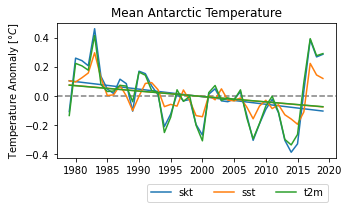

In [9]:
fig = plt.figure(figsize=(5,2.5))
plt.axhline(0, color = 'black',alpha = 0.5, linestyle='--')
gradient = xr.Dataset()
dscopy = ds.stack(z=('x','y')).dropna(dim='z').unstack().copy()
for t in ds:
    data = (dscopy[t]*area).mean(dim=('x','y'))/area.mean(dim=('x','y'))
    m, b = data.polyfit(deg=1, dim='time').polyfit_coefficients 
    yfit = m*data.time.astype(float) +b
    plot = plt.plot(data.time, data,label = t)
    plt.plot(data.time, yfit, color = plot[0].get_color())
plt.legend(bbox_to_anchor=(0.99, -0.15), ncol = 3, loc = 'upper right')
plt.title('Mean Antarctic Temperature')
plt.ylabel('Temperature Anomaly [$\degree C$]')
plt.savefig('images/week6/TemperatureTimeseries_filtered.pdf', bbox_inches='tight')
plt.show()

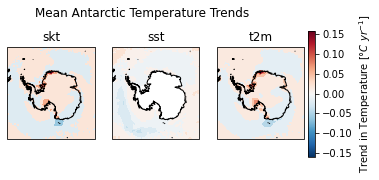

In [10]:
fig = plt.figure(figsize=(5,2.5))

gradient = xr.Dataset()
for t in ds:
    gradient[t] = ds[t].polyfit(deg=1, dim='time').polyfit_coefficients.sel(degree=1)* 1e9*60*60*24*365

max_ = max([gradient[indexname].max() for indexname in gradient])
min_ = min([gradient[indexname].min() for indexname in gradient])

max_ = max(max_,-min_)
min_ = -max_

if max_>min_ and max_>0 and min_<0:
    divnorm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
else:
    sys.exit(f'min = {min_.values}, max = {max_.values}, {variables}')
i=0
for t in ds:
    ax = fig.add_subplot(1,3,i+1, projection = ccrs.SouthPolarStereo())
    data = gradient[t]
    contour = ax.contourf(data.x, data.y, data, cmap='RdBu_r', norm=divnorm)
    ax.set_title(t)
    ax.coastlines()
    i +=1
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=divnorm, cmap='RdBu_r'), cax=cbar_ax, shrink=0.88)
cbar.set_label('Trend in Temperature [$\degree C\ yr^{-1}$]')
plt.suptitle('Mean Antarctic Temperature Trends')
plt.savefig('images/week6/Temperature_Trends.pdf', bbox_inches='tight')
plt.show()

In [11]:
v = [v for v in ds]

correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm.tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1]
    vec2 = ds[v2]
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values
    
def fmt(val):
    sig_level=0.9
    if val > sig_level or val < -sig_level:
        return f'\\textbf{{{val:.3f}}}'
    else:
        return f'{{{val:.3f}}}'

pd.set_option('display.float_format', fmt)
correlation_matrix.index = [f'\\textbf{{{ind.upper()}}}' for ind in correlation_matrix.index]
correlation_matrix.columns = [f'\\textbf{{{ind.upper()}}}' for ind in correlation_matrix.columns]
correlation_matrix.to_latex('images/week6/temperature_correlations.tex', escape=False)
correlation_matrix

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.90it/s]


,\textbf{SKT},\textbf{SST},\textbf{T2M}
\textbf{SKT},\textbf{1.000},{0.585},\textbf{0.963}
\textbf{SST},{0.585},\textbf{1.000},{0.538}
\textbf{T2M},\textbf{0.963},{0.538},\textbf{1.000}


# Regressing Temperature onto Sea Ice

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst', 'skt'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17134.41it/s]


Predicting SIC


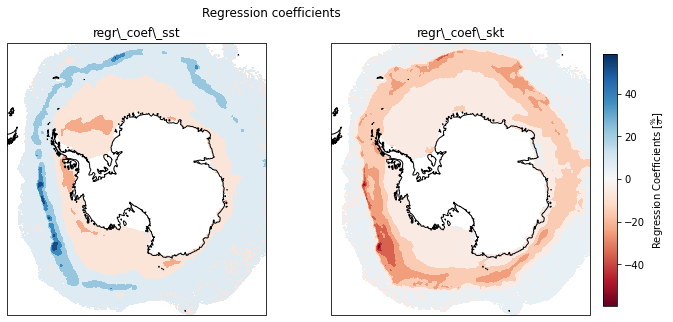

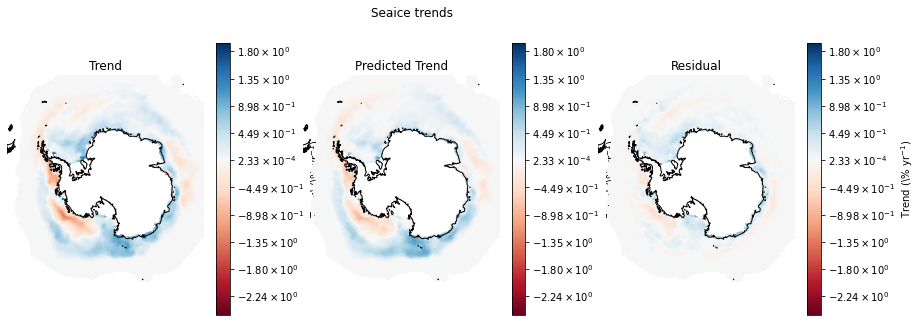

findfont: Font family ['computer modern'] not found. Falling back to DejaVu Sans.


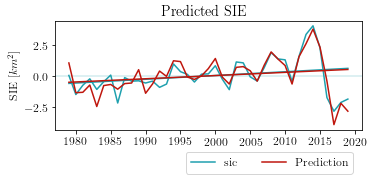

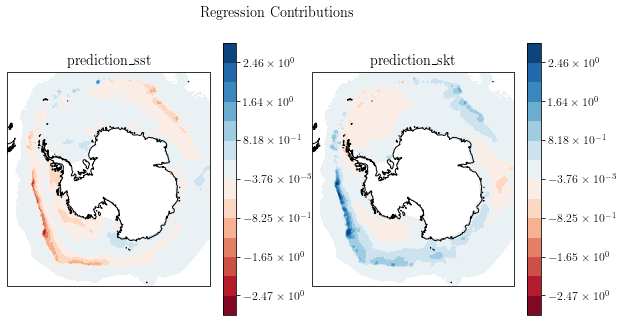

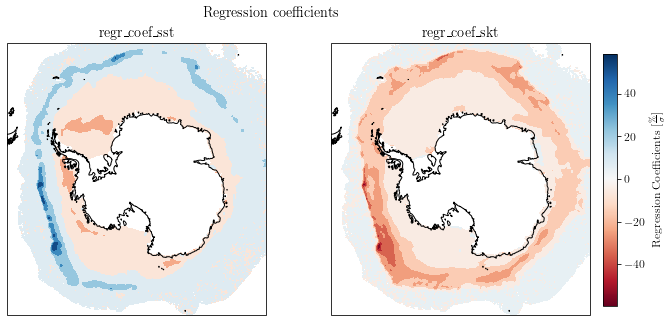

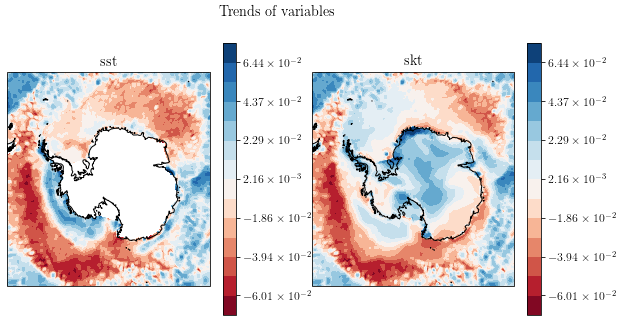

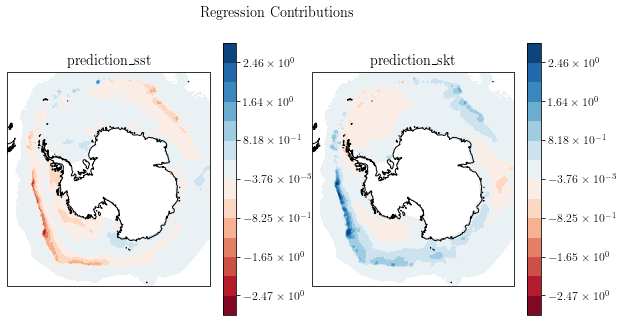

In [12]:
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files, parallel=True, compat='override')

dependant = 'sic'
independant = ['sst', 'skt']
ds = ds[independant + [dependant]]

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant='sic')
     ).compute()

print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant, folder='week6')
w5.more_plotting(regression_results, dependant, independant, folder='week6')

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst', 't2m'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17198.74it/s]


Predicting SIC


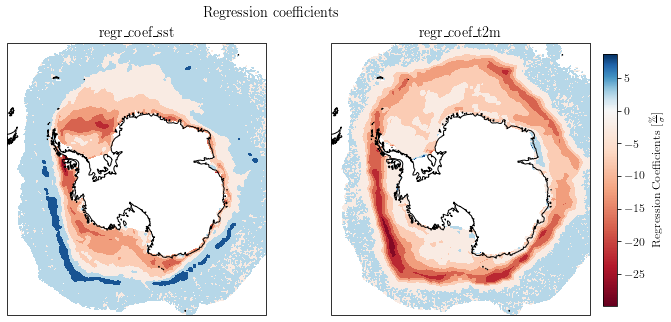

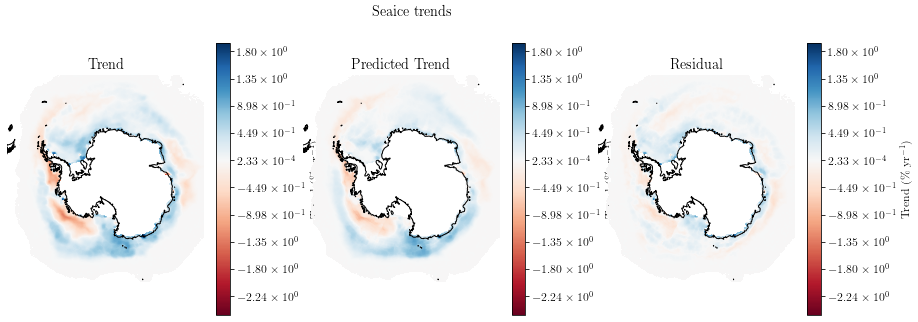

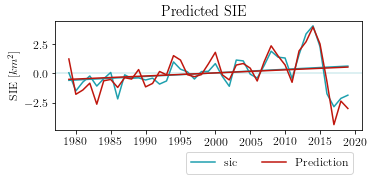

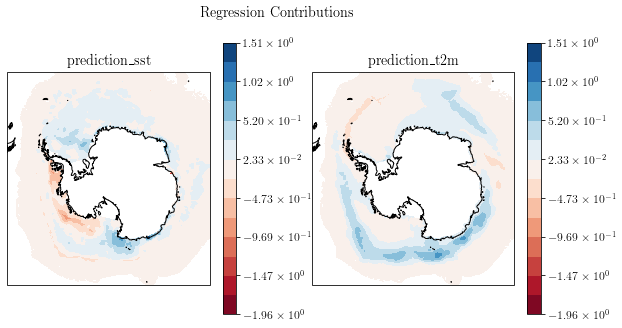

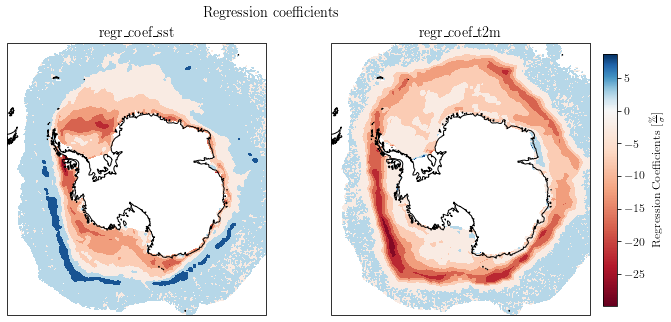

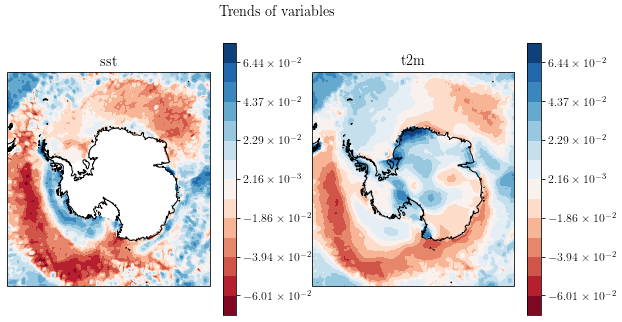

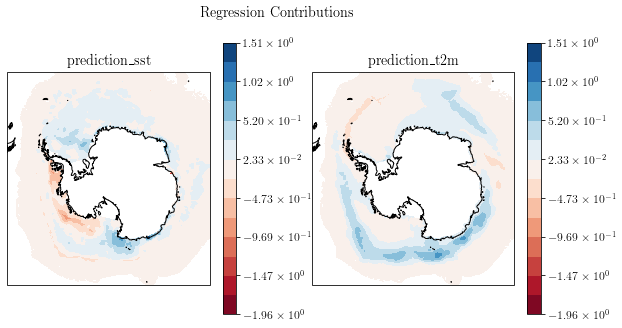

In [13]:
files = glob.glob('processed_data/*')
files = [f for f in files if '_' not in f.split('\\')[1]]
ds = xr.open_mfdataset(files, parallel=True, compat='override')

dependant = 'sic'
independant = ['sst', 't2m']
ds = ds[independant + [dependant]]

ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
ds = (ds
      .pipe(w5.find_anomalies)
      .pipe(w5.yearly_average)
      .pipe(w5.normalise_indepenant, dependant='sic')
     ).compute()

print(ds)

regression_results = w4.multiple_fast_regression(ds, dependant, independant)
w5.plotting(regression_results, dependant, independant, folder='week6')
w5.more_plotting(regression_results, dependant, independant, folder='week6')

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    sst      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.311 -1.339 -1.457
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['sst'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:05<00:00, 17697.67it/s]


Predicting SIC


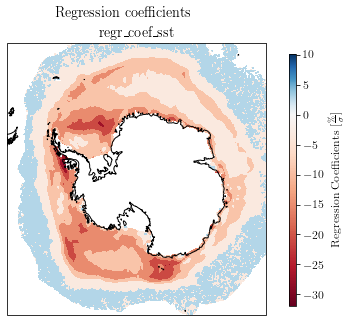

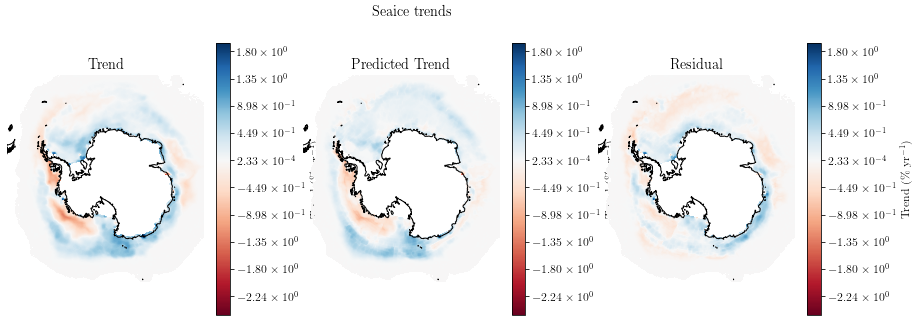

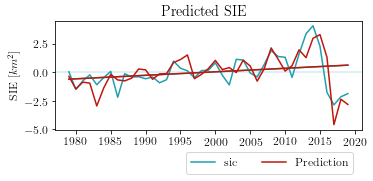

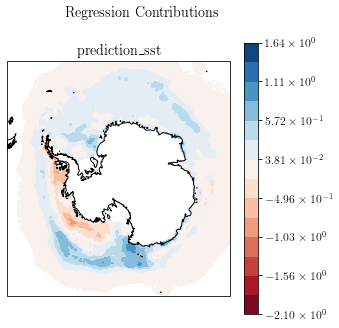

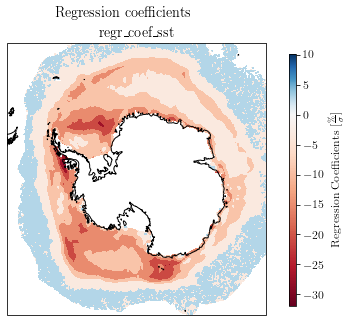

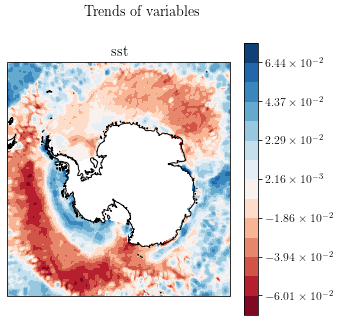

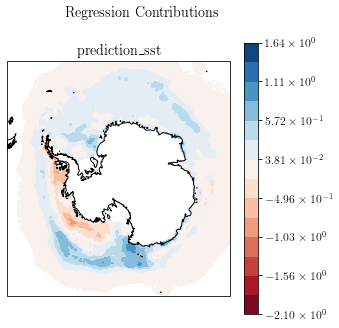

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    skt      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.308 -1.336 -1.453
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['skt'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17355.47it/s]


Predicting SIC


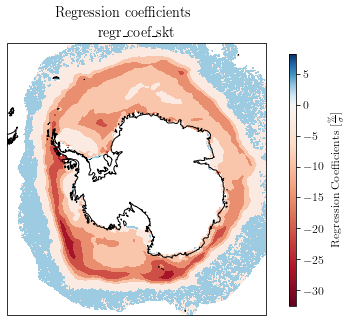

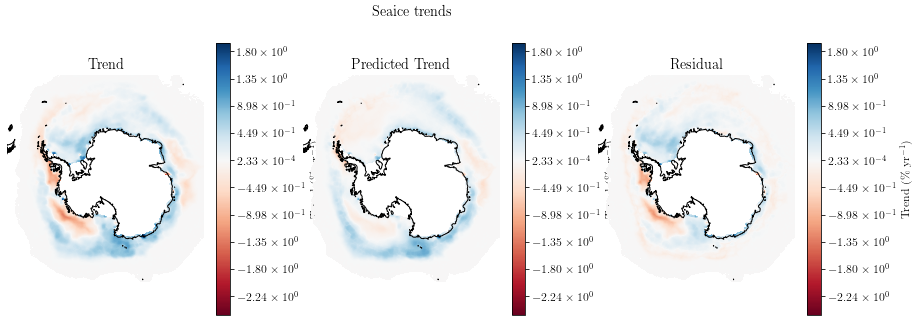

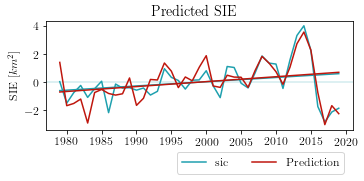

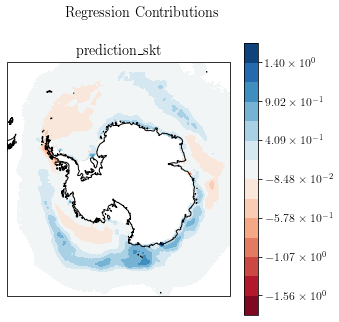

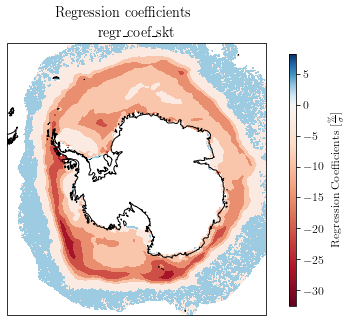

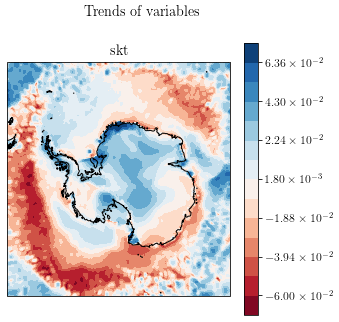

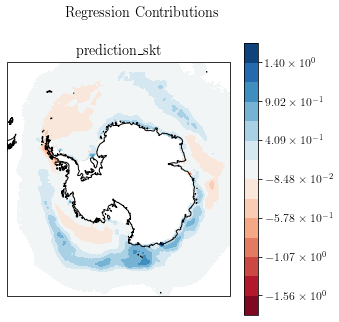

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    t2m      (time, y, x) float64 0.0 0.0 0.0 0.0 ... -1.503 -1.526 -1.576
    sic      (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Finding coefficients for ['t2m'] against sic


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104912/104912 [00:06<00:00, 17278.82it/s]


Predicting SIC


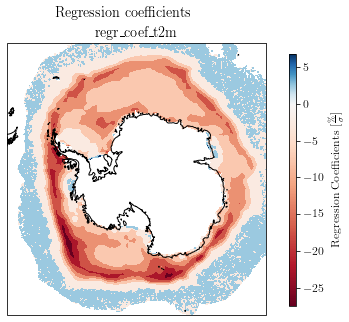

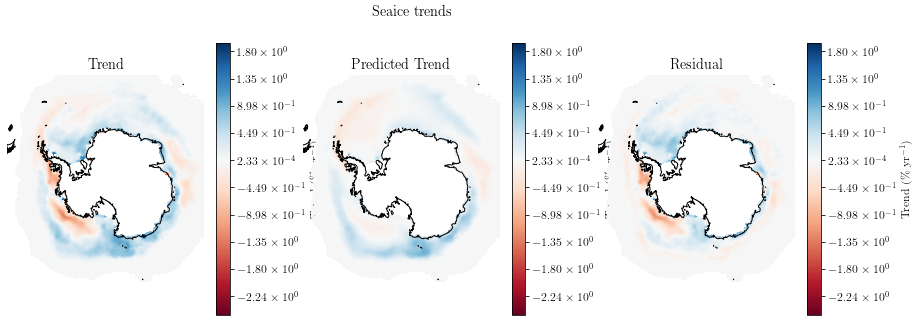

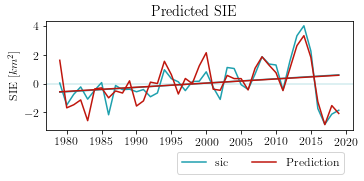

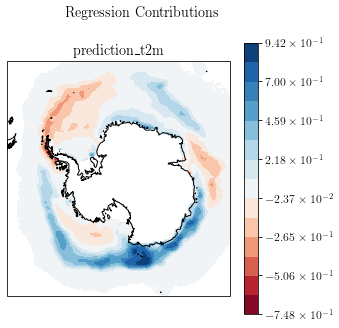

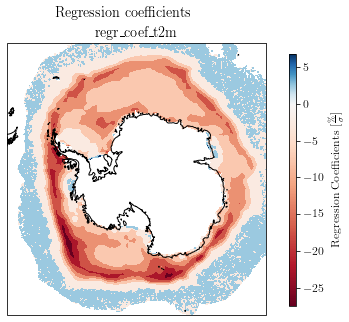

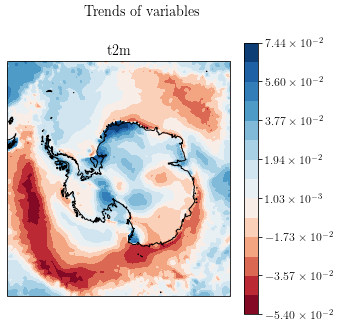

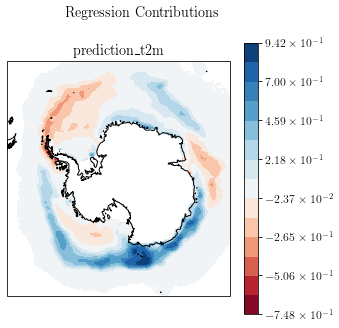

In [14]:
for ind in ['sst','skt','t2m']:
    files = glob.glob('processed_data/*')
    files = [f for f in files if '_' not in f.split('\\')[1]]
    ds = xr.open_mfdataset(files, parallel=True, compat='override')

    dependant = 'sic'
    independant = [ind]
    ds = ds[independant + [dependant]]

    ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
    ds = (ds
          .pipe(w5.find_anomalies)
          .pipe(w5.yearly_average)
          .pipe(w5.normalise_indepenant, dependant='sic')
         ).compute()

    print(ds)

    regression_results = w5.multiple_fast_regression(ds, dependant, independant)
    w5.plotting(regression_results, dependant, independant, folder='week6')
    w5.more_plotting(regression_results, dependant, independant, folder='week6')

# Statistics of fitting